<a href="https://colab.research.google.com/github/the-cafehopper/Research/blob/main/Can_digital_trade_power_energy_inclusion_202507.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# load the excel file
xls = pd.ExcelFile("/content/Master dataset_Can Digital Trade Power Energy Inclusion_202507.xlsx")
print(xls.sheet_names) # check available sheets

FileNotFoundError: [Errno 2] No such file or directory: '/content/Master dataset_Can Digital Trade Power Energy Inclusion_202507.xlsx'

In [ ]:
solar_df = xls.parse('solar_imports')
solar_clean = solar_df[
    (solar_df['reporterDesc'].isin(['Indonesia', 'Philippines', 'Viet Nam'])) &
    (solar_df['refYear'].between(2015, 2022)) &
    (solar_df['cmdCode'] == 854140)
][['reporterDesc', 'refYear', 'primaryValue', 'Source']]

solar_clean = solar_clean.rename(columns={
    'reporterDesc': 'Country',
    'refYear': 'Year',
    'primaryValue': 'SolarImports',
    'Source': 'Source'
})

In [ ]:
findex_df = xls.parse('mobile_money, digital_platform_')

findex_clean = findex_df[[
    'Country name', 'Year',
    'Mobile money account (% age 15+)',
    'Used a mobile phone or the internet to buy something online (% age 15+)',
    'Source',
]].rename(columns={
    'Country name': 'Country',
    'Mobile money account (% age 15+)': 'MobileMoney',
    'Used a mobile phone or the internet to buy something online (% age 15+)': 'DigitalPlatformUsage',
    'Source': 'Source'
})

# normalize country name
findex_clean['Country'] = findex_clean['Country'].replace({'Vietnam': 'Viet Nam'})

In [ ]:
ecomm_df = xls.parse('ecomm_readiness')

ecomm_clean = ecomm_df[['CountryName', 'IndicatorValue', 'Source']]

ecomm_clean = ecomm_clean.rename(columns={
    'CountryName': 'Country',
    'IndicatorValue': 'EcommReadiness',
})

ecomm_clean['Year'] = 2015

In [ ]:
core_df = xls.parse('Data')

# reshape to panel format
data_trimmed = core_df.iloc[:, :23]

data_long = pd.melt(
    data_trimmed,
    id_vars=['Variable Name', 'Country Name', 'Country Code'],
    var_name='Year',
    value_name='Value'
)

# Replace '..' with NaN in the 'Value' column
data_long['Value'] = data_long['Value'].replace('..', pd.NA)

# Convert 'Value' column to numeric, coercing errors to NaN
data_long['Value'] = pd.to_numeric(data_long['Value'], errors='coerce')


# Extract year and filter out rows where year extraction failed
data_long['Year'] = data_long['Year'].str.extract(r'(\d{4})')
data_long = data_long.dropna(subset=['Year'])
data_long['Year'] = data_long['Year'].astype(int)


data_pivot = data_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Variable Name',
    values='Value'
).reset_index()

data_pivot['Country Name'] = data_pivot['Country Name'].replace({'Vietnam': 'Viet Nam'})

data_pivot = data_pivot.rename(columns={
    'Country Name': 'Country',
    'rural_elec_access': 'RuralElecAccess',
    'broadband_penetration': 'BroadbandPenetration',
    'customs_performance': 'CustomsPerformance',
    'gdp_per_capita': 'GDPperCapita'
})

# normalize country name
data_pivot['Country'] = data_pivot['Country'].replace({'Vietnam': 'Viet Nam'})

# previwe results
data_pivot.head()

Variable Name,Country,Year,BroadbandPenetration,CustomsPerformance,GDPperCapita,RuralElecAccess
0,Indonesia,2010,10.9,2.430000,2670.812910,89.4
1,Indonesia,2011,12.3,NaN,2799.624688,90.2
2,Indonesia,2012,14.5,2.530000,2930.518445,92.6
3,Indonesia,2013,14.9,NaN,3055.242460,93.0
4,Indonesia,2014,17.1,2.869565,3170.721030,94.0


In [ ]:
# strip whitespace and unify country names
for df in [solar_clean, findex_clean, ecomm_clean, data_pivot]:
  df['Country'] = df['Country'].str.strip()
  df['Country'] = df['Country'].replace({'Vietnam': 'Viet Nam'})

# ensure Year is integer in all dataframes
for df in [solar_clean, findex_clean, ecomm_clean, data_pivot]:
  df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# drop rows where Country or Year is missing
for df in [solar_clean, findex_clean, ecomm_clean, data_pivot]:
  df.dropna(subset=['Country', 'Year'], inplace=True)

# try merging again
from functools import reduce

dfs = [solar_clean, findex_clean, ecomm_clean, data_pivot]
master_df = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='outer'), dfs)
master_df = master_df.sort_values(by=['Country', 'Year']).reset_index(drop=True)

# display to verify
display(master_df.head())

,Country,Year,SolarImports,Source_x,MobileMoney,DigitalPlatformUsage,Source_y,EcommReadiness,Source,BroadbandPenetration,CustomsPerformance,GDPperCapita,RuralElecAccess
0,Indonesia,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9,2.430000,2670.812910,89.4
1,Indonesia,2011,NaN,NaN,NaN,NaN,https://www.worldbank.org/en/publication/globa...,NaN,NaN,12.3,NaN,2799.624688,90.2
2,Indonesia,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,2.530000,2930.518445,92.6
3,Indonesia,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.9,NaN,3055.242460,93.0
4,Indonesia,2014,NaN,NaN,0.004496,NaN,https://www.worldbank.org/en/publication/globa...,NaN,NaN,17.1,2.869565,3170.721030,94.0


In [ ]:
master_df.to_excel("Cleaned_Merge_Master.xlsx", index=False)

In [ ]:
# empirical analysis
import pandas as pd

df = pd.read_excel("/content/Cleaned_Merge_Master.xlsx")
df.head()

,Country,Year,SolarImports,MobileMoney,DigitalPlatformUsage,EcommReadiness,BroadbandPenetration,CustomsPerformance,GDPperCapita,RuralElecAccess,Source_SolarImports,Source_DigitalPlatformUsage,Source_EcommReadiness
0,Indonesia,2010,NaN,NaN,NaN,NaN,10.9,2.430000,2670.812910,89.4,NaN,NaN,NaN
1,Indonesia,2011,NaN,NaN,NaN,NaN,12.3,NaN,2799.624688,90.2,NaN,https://www.worldbank.org/en/publication/globa...,NaN
2,Indonesia,2012,NaN,NaN,NaN,NaN,14.5,2.530000,2930.518445,92.6,NaN,NaN,NaN
3,Indonesia,2013,NaN,NaN,NaN,NaN,14.9,NaN,3055.242460,93.0,NaN,NaN,NaN
4,Indonesia,2014,NaN,0.004496,NaN,NaN,17.1,2.869565,3170.721030,94.0,NaN,https://www.worldbank.org/en/publication/globa...,NaN


In [ ]:
# check for missings
df.isnull().sum()

,0
Country,0
Year,0
SolarImports,20
MobileMoney,33
DigitalPlatformUsage,36
EcommReadiness,39
BroadbandPenetration,0
CustomsPerformance,24
GDPperCapita,0
RuralElecAccess,0


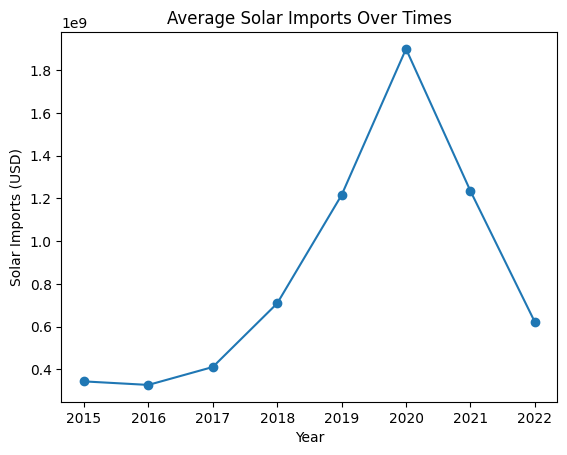

In [ ]:
# plot descriptive trends
import matplotlib.pyplot as plt

df.groupby(['Year'])['SolarImports'].mean().plot(marker='o')
plt.title("Average Solar Imports Over Times")
plt.ylabel("Solar Imports (USD)")
plt.show()

In [ ]:
# build the Digital Trade Readiness Index
# define normalization function
def normalize(series):
  return(series - series.min()) / (series.max() - series.min())

# normalize each component
df['DTRI_Ecomm'] = normalize(df['EcommReadiness'])
df['DTRI_MobileMoney'] = normalize(df['MobileMoney'])
df['DTRI_PlatformUsage'] = normalize(df['DigitalPlatformUsage'])

# combine into final DTRI score (equal weighting)
df['DTRI'] = df[['DTRI_Ecomm', 'DTRI_MobileMoney', 'DTRI_PlatformUsage']].mean(axis=1)

In [ ]:
df['DTRI'].describe()
df[['Country', 'Year', 'DTRI']].sort_values(by='DTRI', ascending=False).head()

,Country,Year,DTRI
33,Viet Nam,2015,1.000000
25,Philippines,2021,0.929017
40,Viet Nam,2022,0.876159
11,Indonesia,2021,0.353728
19,Philippines,2015,0.267327


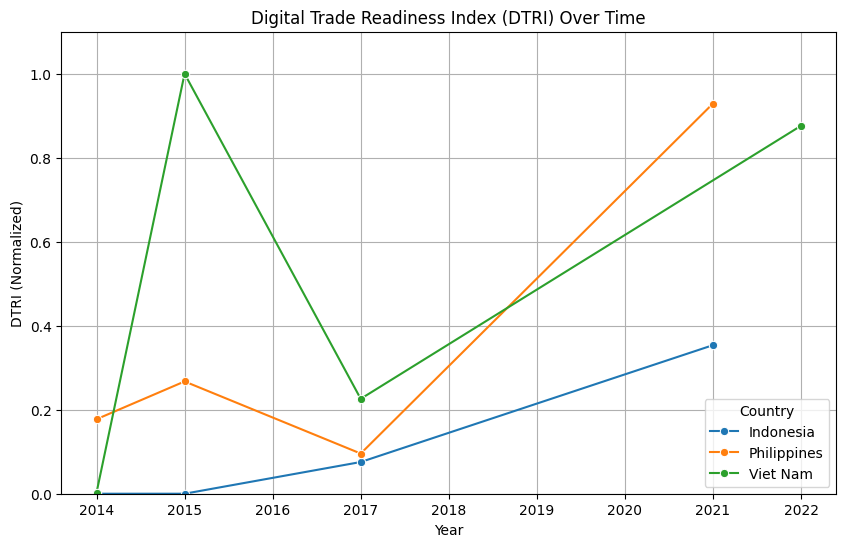

In [ ]:
# trend line by country - DTRI over time
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='DTRI', hue='Country', marker='o')
plt.title('Digital Trade Readiness Index (DTRI) Over Time')
plt.ylabel('DTRI (Normalized)')
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()

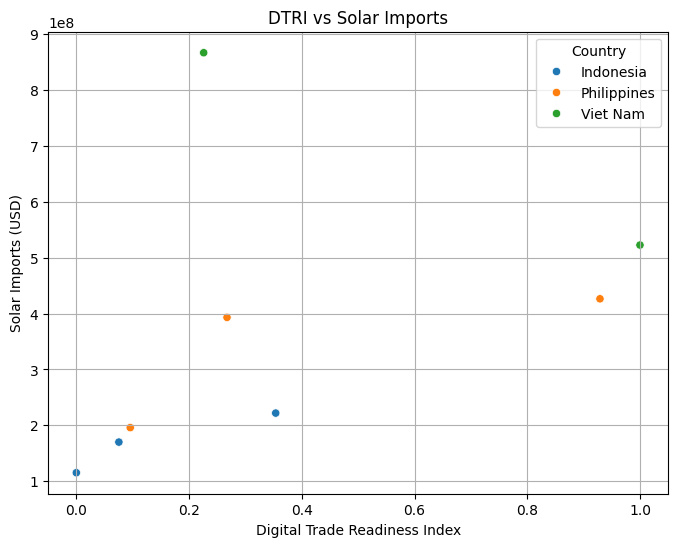

In [ ]:
# scatter plot - DTRI vs solar imports - core relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='DTRI', y='SolarImports', hue='Country')
plt.title('DTRI vs Solar Imports')
plt.xlabel('Digital Trade Readiness Index')
plt.ylabel('Solar Imports (USD)')
plt.grid(True)
plt.show()

In [ ]:
# regression - main model
# hypothesis: does higher digital trade readiness predict greater solar imports?

# simple linear model - baseline
import statsmodels.api as sm

# drop missing values
reg_df = df.dropna(subset=['SolarImports', 'DTRI', 'GDPperCapita'])

# define variables
X = reg_df[['DTRI', 'GDPperCapita']] # independent variables
X = sm.add_constant(X) # add constant (intercept)
y = reg_df['SolarImports'] # dependent variable

# run OLS regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           SolarImports   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1.982
Date:                Sun, 13 Jul 2025   Prob (F-statistic):              0.232
Time:                        13:55:44   Log-Likelihood:                -163.12
No. Observations:                   8   AIC:                             332.2
Df Residuals:                       5   BIC:                             332.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.455e+09   7.36e+08      1.978   

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
# country fixed effects
import statsmodels.formula.api as smf

# convert country to categorical
reg_df['Country'] = reg_df['Country'].astype('category')

# run fixed effects using formula API
model_fe = smf.ols('SolarImports ~ DTRI + GDPperCapita + C(Country)', data=reg_df).fit()
print(model_fe.summary())

                            OLS Regression Results                            
Dep. Variable:           SolarImports   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     3.514
Date:                Sun, 13 Jul 2025   Prob (F-statistic):              0.165
Time:                        13:56:21   Log-Likelihood:                -158.50
No. Observations:                   8   AIC:                             327.0
Df Residuals:                       3   BIC:                             327.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

/tmp/ipython-input-11-3505081379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['Country'] = reg_df['Country'].astype('category')
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
